In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA, KernelPCA
from IPython.display import display
import matplotlib as mp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

## Utiles

In [2]:
from itertools import cycle
from matplotlib import colors
from matplotlib.pyplot import cm
from matplotlib.font_manager import FontProperties

def plot_cls(column, data, legends, alpha=.5, centers=[]):
    """ Función para plotear los datos tomando como ejes "profundidad(m)", "Temperatura" y "sustrato", y agrupando
    en colores según la feature "column" tomada por parámetro """

    c = plt.get_cmap('gist_rainbow')

    name_plot = "Coloración segun {}".format(column)
    colores = iter(cm.rainbow(np.linspace(0,1, len(np.unique(data[column])) )))
    fig = plt.figure(name_plot, figsize=(11,6))
    ax = Axes3D(fig)
    ax.set_title(name_plot)
    
    grupos = data.groupby(column)
    for i, (name, group) in enumerate(grupos):
        c = next(colores)
        ax.scatter(group["Temperatura"], group["sustrato"], group["profundidad(m)"], marker='o', c=c, alpha=alpha,
                   label="{0} ({1} ejemplares)".format(legends[name], group.shape[0]))

    ax.set_xlabel("Temperatura (ºC)")
    ax.set_ylabel("Sustrato (ver tabla)")
    ax.set_zlabel("Profundidad (m)")
    if len(centers)>0:
        for i, c in enumerate(centers):
            ax.text(c[0], c[1], c[2], "c %d"%i,bbox=dict(
                    facecolor='white', alpha=.5, edgecolor='black', boxstyle='round'))

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width *.7, box.height])

    fontP = FontProperties()
    fontP.set_size('small')
    ax.legend(loc="right", prop=fontP, bbox_to_anchor=(1.4, .5))
    plt.show()

### Loading Data

In [3]:
df = pd.read_csv("test_1.csv", sep=";")

df_respaldo = df[["Estacion", "Transecto", "Fecha", "genero", "especie"]]
df_test = df.copy()
df_test[:2]

,Estacion,Estrata,Transecto,Fecha,Salinidad(ppm),Temperatura,pH,profundidad(m),sustrato,genero,especie,total
0,E1,1,I.1.1,12/11/16,33,28.33,8.5,0.5,Roca/Arena,NaN,NaN,0
1,E1,1,I.1.2,12/11/16,33,28.33,8.5,0.5,Roca/Arena,NaN,NaN,0


In [4]:
df_test.drop(axis=1, labels=["Fecha"], inplace=True)

# Unificando features "genero" y "especie"
df_test["gen/esp"] = df_test["genero"].str.cat(df_test["especie"], sep="/")
df_test.drop(axis=1, labels=["Estacion", "Transecto", "genero", "especie"], inplace=True)

In [5]:
df_test["gen/esp"].fillna("Sin Ejemplares", inplace=True)
df_t1 = df_test.copy()

maper_g = {k:v for v, k in enumerate(np.unique(df_test["gen/esp"]))}
legends_g = {v: k for k, v in maper_g.items()}

maper_s = {k:v for v, k in enumerate(np.unique(df_test["sustrato"].fillna("-")))}
legends_s = {v: k for k, v in maper_s.items()}

df_t1["gen/esp"] = df_test["gen/esp"].map(maper_g)
df_t1["sustrato"] = df_test["sustrato"].map(maper_s)

maper_t = {k:str(k)+"ºC" for k in np.unique(df_t1["Temperatura"].fillna("-"))}

Tabla equivalencia Sustratos


,0,1,2,3,4,5,6
sustratos,Arena,Arrecife,Gravilla,Pradera,Pradera/Arena,Roca,Roca/Arena


<IPython.core.display.Javascript object>


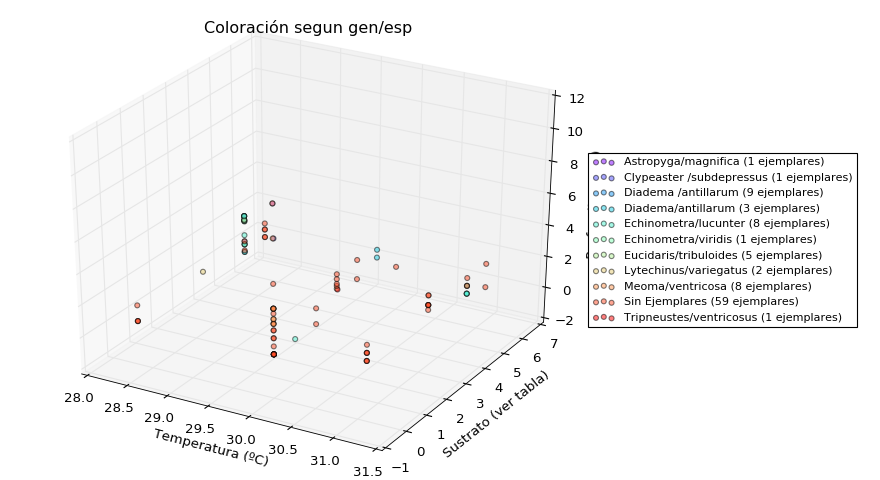

<IPython.core.display.Javascript object>


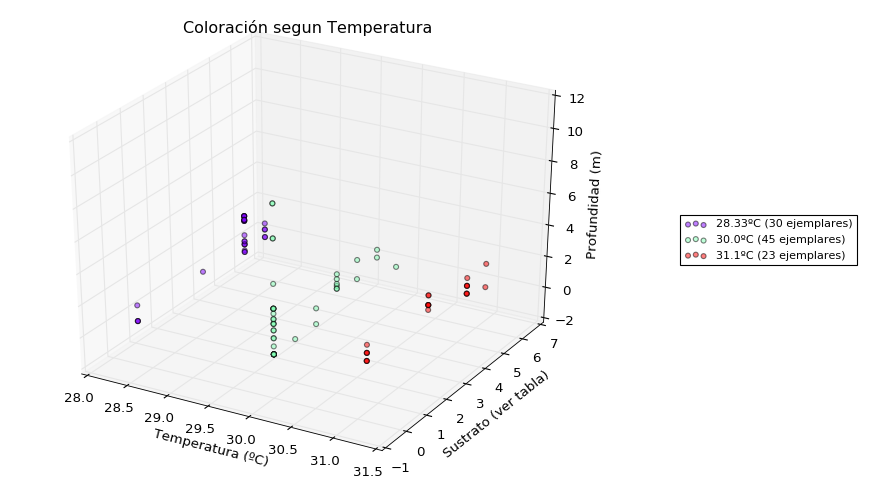

<IPython.core.display.Javascript object>


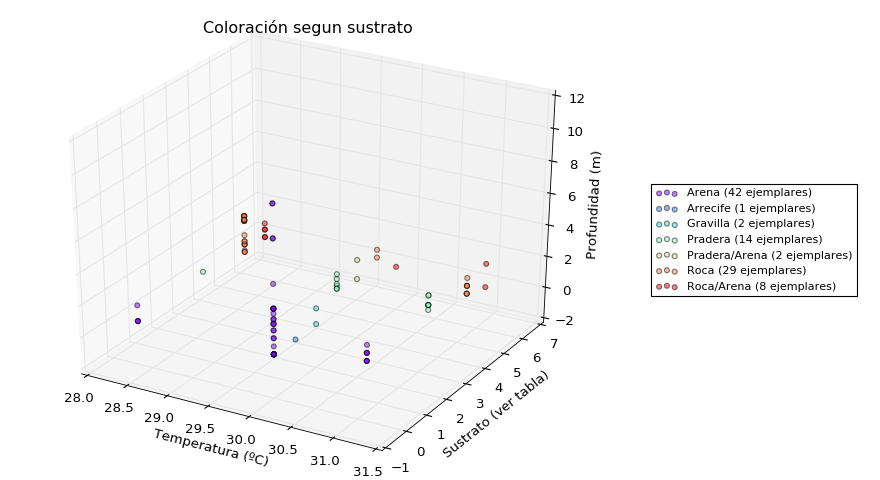

In [6]:
t_sust = pd.DataFrame()
t_sust["sustratos"] = legends_s.values()
print("Tabla equivalencia Sustratos")
display(t_sust.T)
plot_cls("gen/esp", df_t1, legends_g)
plot_cls("Temperatura", df_t1, maper_t)
plot_cls("sustrato", df_t1, legends_s)


### Preparando Datos para ExtraTrees

In [7]:
final = pd.concat([df_test, pd.get_dummies(df_test[["sustrato"]])], axis=1)
final.drop(axis=1, labels=["Estrata", "sustrato", "gen/esp"], inplace=True)
pd.options.display.max_columns = 100
# final.columns

In [8]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

Y = final["total"]
X = final.drop(axis=1, labels=["total"])

pipe = Pipeline([#("vt", VarianceThreshold(.8*(1-.8))),
                 ("sc", preprocessing.StandardScaler())
])

x_data = pd.DataFrame(pipe.fit_transform(X))
x_data.columns = X.columns
final.shape, x_data.values.shape

((98, 12), (98, 11))

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# pca = PCA(n_components=3, random_state=10)
# t_data = pca.fit_transform(x_data)
# print(np.sum(pca.explained_variance_ratio_))

# x_train, x_test, y_train, y_test = train_test_split(x_data, Y, test_size=.25)

forest = ExtraTreesClassifier(n_estimators=250, random_state=10)
forest.fit(x_data, Y.astype(bool))

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=1, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

<IPython.core.display.Javascript object>


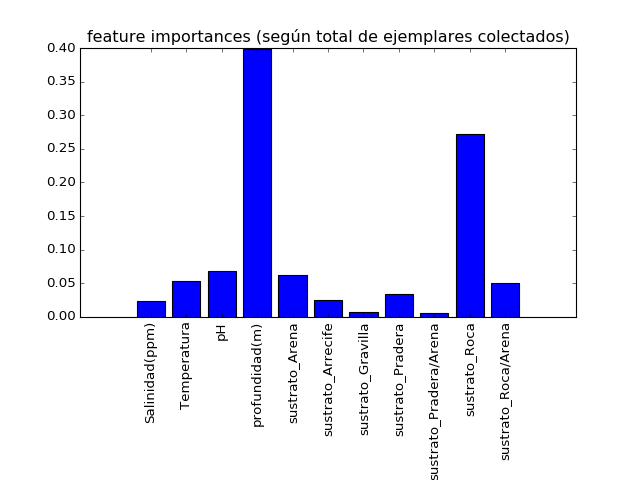

In [10]:
plt.figure("feature importances (según total de ejemplares colectados)")
plt.bar(range(len(forest.feature_importances_)), forest.feature_importances_, align='center')

box = plt.axes().get_position()
plt.axes().set_position([box.x0, box.y0+box.height*.3, box.width, box.height*.7])
plt.xticks(range(len(forest.feature_importances_)), x_data.columns, rotation=90)
plt.axes().set_title("feature importances (según total de ejemplares colectados)")
plt.show()

### Preparando para estimar importancia por especie

In [11]:
prb = df_test.drop(axis=1, labels=["Estrata", "total", "sustrato", "gen/esp"])
prb = pd.concat([prb, pd.get_dummies(df_test["sustrato"].fillna(0))], axis=1)
prb[:2]

,Salinidad(ppm),Temperatura,pH,profundidad(m),Arena,Arrecife,Gravilla,Pradera,Pradera/Arena,Roca,Roca/Arena
0,33,28.33,8.5,0.5,0,0,0,0,0,0,1
1,33,28.33,8.5,0.5,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>


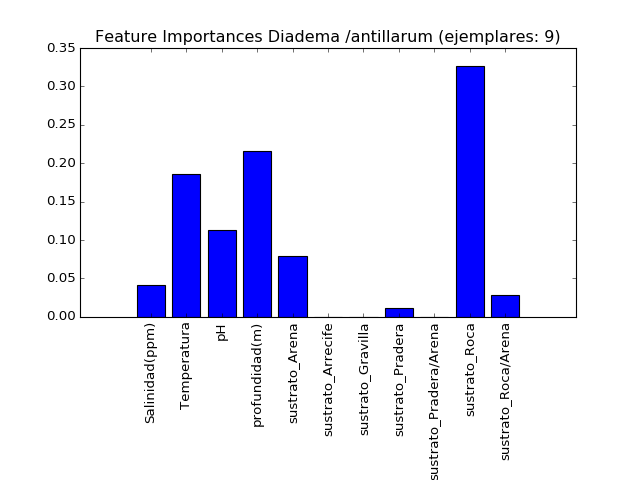

<IPython.core.display.Javascript object>


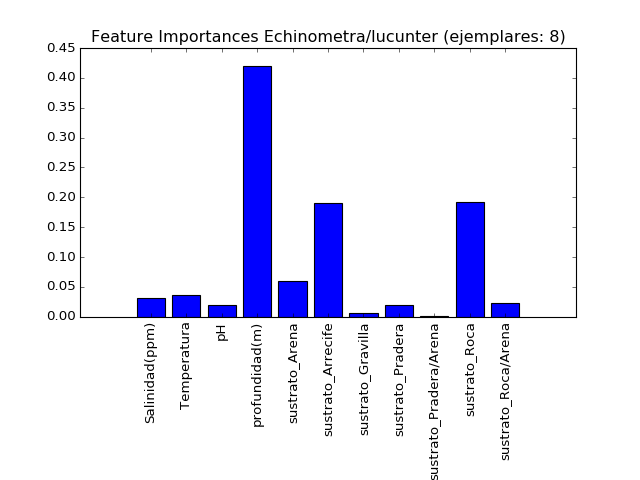

<IPython.core.display.Javascript object>


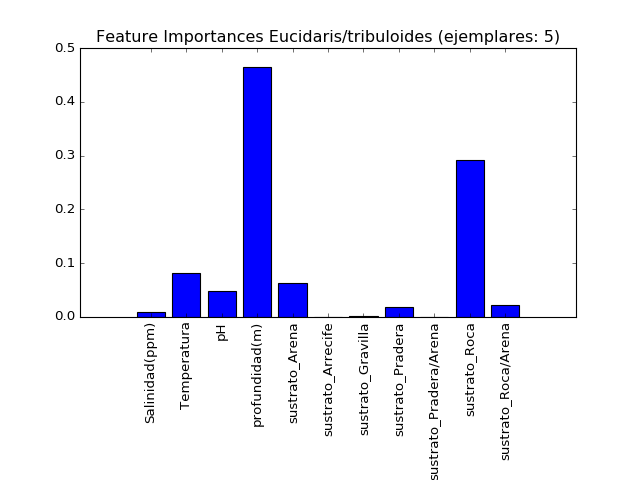

<IPython.core.display.Javascript object>


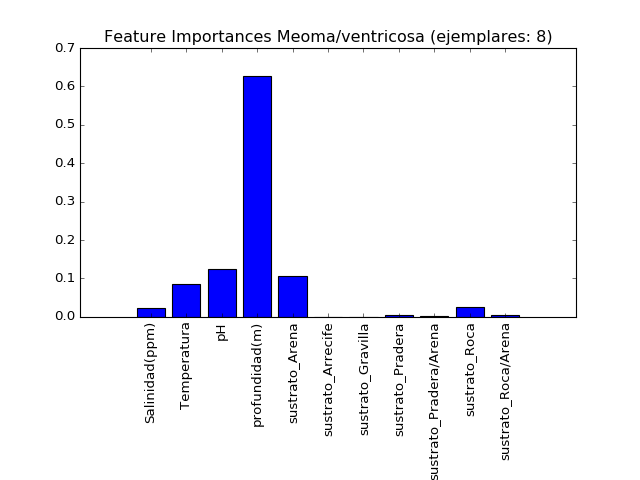

<IPython.core.display.Javascript object>


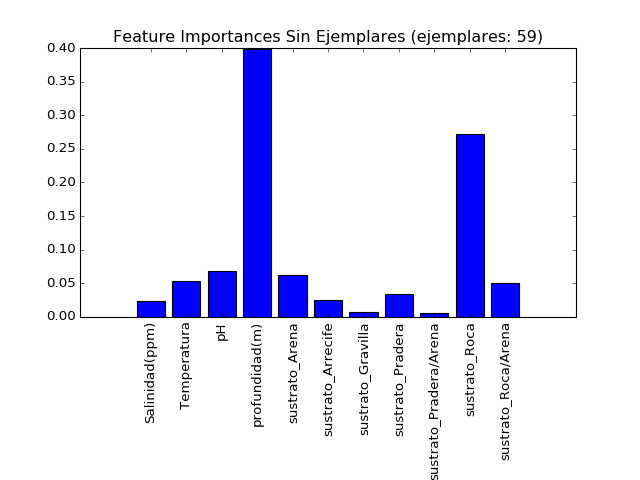

In [15]:
clases = pd.get_dummies(df_test["gen/esp"])

std = preprocessing.StandardScaler()
data = std.fit_transform(prb)
data = pd.DataFrame(data)
data.columns = prb.columns

for c in clases.columns:
    l = clases[c]
    if np.count_nonzero(l) < 4:
        continue
#     print("Total ejemplares de {}: {}".format(c, np.count_nonzero(l)))
    forest_c = ExtraTreesClassifier(n_estimators=250, random_state=10)
    forest_c.fit(data, l.astype(bool))
    
    index = range(len(forest_c.feature_importances_))
    plt.figure("{} feature importances".format(c))
    plt.bar(index, forest_c.feature_importances_, align='center')

    box = plt.axes().get_position()
    plt.axes().set_position([box.x0, box.y0+box.height*.3, box.width, box.height*.7])
    plt.axes().set_title("Feature Importances {} (ejemplares: {})".format(c, np.count_nonzero(l)))
    plt.xticks(index, x_data.columns, rotation=90)
    plt.show()